# Projeto direto de controlador digital

Nas abordagens de projeto direto, tratamos a **planta como um sistema discreto**, de modo que o controlador projetado é obtido diretamente como uma função de transferência discreta.

Desta forma, iniciamos o projeto direto obtendo um equivalente discreto da planta. Para isso, você deve selecionar um período de amostragem adequado e utilizar um dos equivalentes que aprendemos:
- Tustin/Bilinear/Trapezoidal
- Mapeamento
- ZOH

Para o método ZOH, vale destacar que ele pode ser aplicado tanto para a planta modelada por função de transferência como para matrizes de espaço de estados. Mais sobre isso adiante.

De um modo geral, as técnicas de projeto digital (ou no plano Z) são muito semelhantes às do projeto analógico. A diferença fundamental é a região de estabilidade de pólos, que no plano Z, é o interior do círculo unitário.

Eventualmente, deve-se também lembrar da relação fundamental $z = \exp(sT)$ para fazer o mapeamento entre pólos do plano $s$, que é mais intuitivo fisicamente, para o plano $Z$. 

## LGR discreto

As regras de associação de sistemas em tempo discreto **são as mesmas** para tempo contínuo. Assim, a equação característica de uma malha de controle digital proporcional é a mesma do caso analógico:
$$
    1+ K G(z) = 0
$$

Dessa forma, as **regras de traçado do LGR discreto são as mesmas do LGR contínuo**.

O algoritmo de projeto segue os mesmos passos, bastando atentar que a região de estabilidade é diferente, isto é, o LGR deve passar aproximadamente em uma região no interior do círculo unitário.

Observe que devido à sua forma geométrica, o LGR sempre vai conter ramos fora do círculo, indicando que em algum momento o aumento do ganho vai instabilizar a malha. Contudo, fique atento ao fato de que as coisas no plano Z acontecem em escala logaritmica, então podem ser necessários ganhos muito altos para poder realmente instabilizar o controle.

**Exemplo:** Controle de um sistema de primeira ordem:
$$
    G(s) = \frac{20}{2s+1}
$$

In [1]:
import control as ct
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt

In [2]:
T = 0.1
G = ct.tf([20],[2,1])
Gz = ct.c2d(G,T)
Gz

TransferFunction(array([0.97541151]), array([ 1.        , -0.95122942]), 0.1)

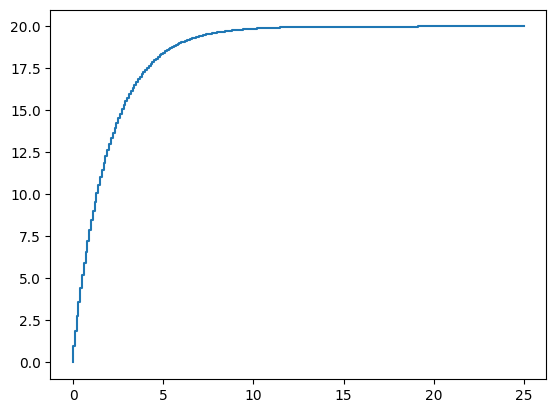

In [17]:
resp = ct.step_response(Gz)
plt.step(resp.t, resp.outputs)
plt.show()

In [36]:
Ts = 5
xi = np.sqrt(2)/2
wn = 4/(Ts*xi)
s = wn*(-xi+1j*np.sqrt(1-xi**2))
print(s)
MF = np.exp(s*T)
print(MF)

(-0.8+0.7999999999999999j)
(0.9201639491940385+0.07377056031942882j)


In [47]:
a = Gz.pole()[0]
print(a)
p2 = 2*np.real(MF)-1
print(p2)
GGz = lambda z: np.polyval(Gz.num[0][0],z)/np.polyval(Gz.den[0][0],z)
numC = np.array([1,-a])
denC = np.poly([1,p2])
CCz = lambda z: np.polyval(numC,z)/np.polyval(denC,z)
print(CCz(MF))
K = 1/abs(CCz(MF)*GGz(MF))
K

(0.951229424500714+0j)
0.8403278983880771
(2.6291268610901573-6.243334755988903j)


0.0121137493838959

In [49]:
Cz = ct.tf(numC*K,denC,T)
Cz


TransferFunction(array([ 0.01211375+0.j, -0.01152295-0.j]), array([ 1.       , -1.8403279,  0.8403279]), 0.1)

In [52]:
mfz = ct.feedback(Cz*Gz,1)
_ = ct.damp(mfz)
print(mfz.zeros())

_____Eigenvalue______ Damping___ Frequency_
    0.9512                     1    -0.9512
    0.9202  +0.07377j     0.7071      1.131
    0.9202  -0.07377j     0.7071      1.131
[0.95122942-0.j]


c:\Users\rafael\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\xferfcn.py:1047: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\rafael\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\xferfcn.py:1077: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


c:\Users\rafael\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


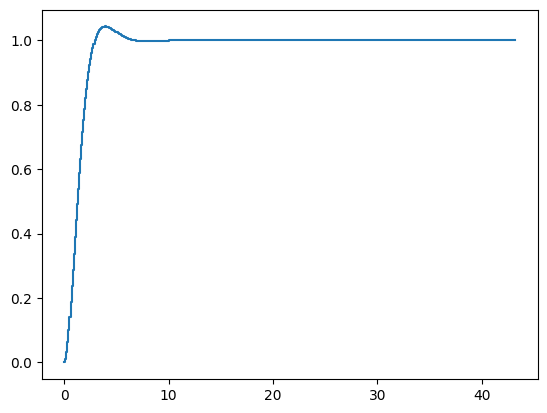

{'RiseTime': 1.9000000000000004,
 'SettlingTime': 5.4,
 'SettlingMin': 0.9010763029945696,
 'SettlingMax': 1.0432677955408636,
 'Overshoot': 4.326779553954455,
 'Undershoot': 0,
 'Peak': 1.0432677955408636,
 'PeakTime': 4.0,
 'SteadyStateValue': 1.0000000000012643}

In [57]:
resp = ct.step_response(mfz)
plt.step(resp.t, resp.outputs)
plt.show()
ct.step_info(mfz)

c:\Users\rafael\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


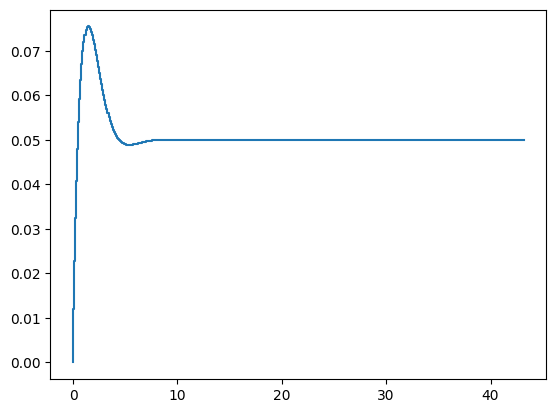

In [55]:
MFU = ct.tf(Cz/(1+Cz*Gz))
resp = ct.step_response(MFU)
plt.step(resp.t, resp.outputs)
plt.show()

## Espaço de estados discreto.

A representação de estados discreta é muito semelhante ao caso contínuo. 

$$
\begin{align}
    \mathbf{x}[k+1] &= \mathbf{\Phi}\mathbf{x}[k]+\mathbf{\Gamma}u[k]\\
    y[k] &= \mathbf{C}\mathbf{x}[k]+{D}u[k]
\end{align}
$$

onde as matrizes $\mathbf{C}$ e $D$ discretas são as mesmas da representação contínua. 

As matrizes $\mathbf{\Phi}$ e $\mathbf{\Gamma}$ são as equivalentes ZOH das matrizes $\mathbf{A}$ e $\mathbf{B}$ do sistema contínuo e podem ser calculadas como (demonstração omitida):
$$
\begin{align}
    \mathbf{\Phi} &= e^{\mathbf{A}T} = \left.\mathcal{L}^{-1}\{(sI-\mathbf{A})^{-1}\}\right|_{t=T}\\
    \mathbf{\Gamma} &= \int_0^T e^{\mathbf{A}h}\mathbf{B} \,dh
\end{align}
$$

Todas as regras de análise permanecem as mesmas:  
* Os pólos do sistema também são os autovalores de $\mathbf{\Phi}$
* A função de transferência é $\mathbf{C}(z\mathbf{I-\Phi})^{-1}\mathbf{\Gamma}+D$
* A lei de controle é da família $u = - \mathbf{Kx}$
* O observador de estados é formulado e resolvido da mesma forma que o contínuo
* Podemos usar a fórmula de Ackermann pra resolver os problemas do observador e regulador


O controle integral é resolvido de uma forma ligeiramente diferente. O estado aumentado é descrito como
$$
    e[k+1] = e[k] + r[k]-\mathbf{Cx}[k]
$$

Portanto a matriz aumentada deve ser:
$$
    \mathbf{\Phi}_a = \left[\begin{array}{rr} 
    \mathbf{\Phi} & 0 \\
    -\mathbf{C} &1\end{array}\right]
$$

**Exemplo:** estabilização de um sistema com pólos simétricos (MAGLEV/Pêndulo invertido/etc.)
$$
    G(s) = \frac{50}{s^2-9}
$$


In [63]:
G = ct.tf([50],[1,0,-9])
G = ct.tf2ss(G)
print(G)
print(G.poles())

A = [[-0.  9.]
     [ 1.  0.]]

B = [[1.]
     [0.]]

C = [[ 0. 50.]]

D = [[0.]]

[-3.+0.j  3.+0.j]


In [64]:
f = 3/(2*np.pi)
print(f)
f = 10
T = 1/f
T

0.477464829275686


0.1

In [71]:
sys = ct.c2d(G,T)
print(sys)
sys.zeros()

A = [[1.04533851 0.91356088]
     [0.10150676 1.04533851]]

B = [[0.10150676]
     [0.00503761]]

C = [[ 0. 50.]]

D = [[0.]]

dt = 0.1



array([-1.+0.j])

In [76]:
Phi_a = np.block([[sys.A, np.zeros((2,1))],[-sys.C,1]])
Gamma_a = np.block([[sys.B],[0]])
s = np.array([-7, -7])
z = np.block([np.exp(s*T),0])
print(z)
K = ct.acker(Phi_a,Gamma_a,z)
print(K)
po = z/2
po

[0.4965853 0.4965853 0.       ]
[[ 14.63347422 121.50791222  -0.50306836]]


array([0.09931706, 0.09931706, 0.        ])

## Resposta em frequência discreta

A análise de resposta em frequência é feita substituindo-se $s=j\omega$ no domínio contínuo. A resposta em frequência de um sistema $G(s)$ é normalmente denotada pelo módulo e fase de $G(j\omega)$

Como $z=e^{sT}$, é direta a dedução que a análise de resposta em frequência de uma função de transferência pulsada $\hat{G}(z)$ é feita com $\hat{G}(e^{j\omega T})$. 

A interpretação física no domínio discreto permanece a mesma. No entanto, devemos ter em mente que não podemos analisar para frequências arbitrariamente altas, pois a análise não pode violar o teorema da amostragem.

Na prática, plotamos a reposta em frequência do sistema até a chamada frequência de Nyquist, que é metade da frequência de amostragem. 